In [1]:
import numpy as np
from sympy import *
from bikewheelcalc import BicycleWheel
from IPython.display import display

init_printing()

In [2]:
# setup symbols
s = symbols('s', real=true)

# deformation
u = Function('u')
v = Function('v')
w = Function('w')
phi = Function('phi')

# rim properties
R, EA, EI1, EI2, GJ, EIw, mu, rx, ry, y0 = symbols('R EA EI_1 EI_2 GJ EI_w mu r_x r_y y_0',
                                                   real=true, finite=true,
                                                   positive=true)

t = symbols('t', real=true)  # Average net radial pull per unit length

# spoke properties
k_uu, k_vv, k_ww, k_pp = symbols('k_uu k_vv k_ww, k_{\phi\phi}', real=true)
k_uv, k_uw, k_up, k_vw, k_vp, k_wp = symbols('k_uv k_uw k_{u\phi} k_vw k_{v\phi} k_{w\phi}', real=true)

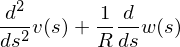

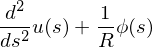

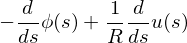

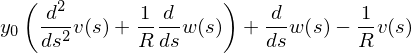

In [3]:
# curvatures
k_1 = v(s).diff(s, 2) + w(s).diff(s)/R
k_2 = u(s).diff(s, 2) + phi(s)/R
k_3 = u(s).diff(s)/R - phi(s).diff(s)
e_mem = w(s).diff(s) - v(s)/R + y0*(v(s).diff(s, 2) + w(s).diff(s)/R)

display(k_1)
display(k_2)
display(k_3)
display(e_mem)

In [4]:
u_rim = (EI1*k_1**2 + EI2*k_2**2 + GJ*k_3**2 + EIw*(k_3.diff(s))**2)/2 + EA*e_mem**2/2

u_spokes = (k_uu*u(s)**2 + 2*k_uv*u(s)*v(s) + 2*k_uw*u(s)*w(s) + 2*k_up*u(s)*phi(s) +
            k_vv*v(s)**2 + 2*k_vw*v(s)*w(s) + 2*k_vp*v(s)*phi(s) +
            k_ww*w(s)**2 + 2*k_wp*w(s)*phi(s) +
            k_pp*phi(s)**2)/2

v_rim = R*t*(u(s).diff(s)**2 + rx**2*phi(s).diff(s)**2 +
             ry**2*(u(s).diff(s)/R - phi(s).diff(s))**2 +
             y0*(2*u(s).diff(s, 2)*phi(s) - phi(s)**2/R) +
             y0**2*phi(s).diff(s)**2)/2

In [5]:
n = symbols('n', integer=True)
npos = symbols('n', integer=True, positive=True)

u_c, u_s, v_c, v_s, w_c, w_s, p_c, p_s = symbols('u_c u_s v_c v_s w_c w_s phi_c phi_s', real=True)

d = [u_c, u_s, v_c, v_s, w_c, w_s, p_c, p_s]

f_subs = [(u(s), u_c*cos(n*s/R) + u_s*sin(n*s/R)),
          (v(s), v_c*cos(n*s/R) + v_s*sin(n*s/R)),
          (w(s), w_c*cos(n*s/R) + w_s*sin(n*s/R)),
          (phi(s), p_c*cos(n*s/R) + p_s*sin(n*s/R))]

U_rim = integrate(u_rim.subs(f_subs).doit(), (s, 0, 2*pi*R))
U_spokes = integrate(u_spokes.subs(f_subs).doit(), (s, 0, 2*pi*R))
V_rim = integrate(v_rim.subs(f_subs).doit(), (s, 0, 2*pi*R))

# Rim stiffness matrix

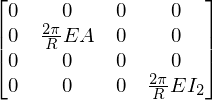

In [6]:
K_rim_0 = zeros(4)

for i in range(4):
    for j in range(4):
        K_rim_0[i, j] = U_rim.subs(n, 0).diff(d[2*i]).diff(d[2*j])
        
display(K_rim_0)

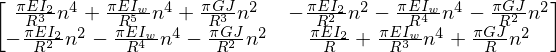

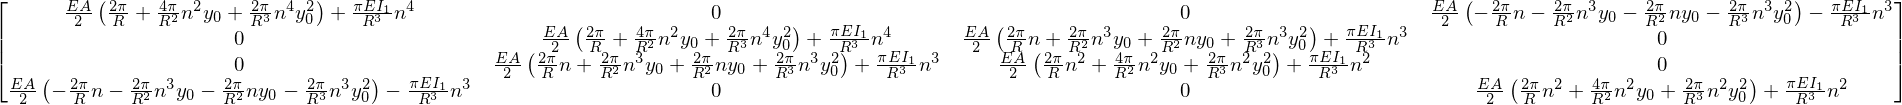

In [7]:
K_rim_n = zeros(8)

for i, m1 in enumerate(d):
    for j, m2 in enumerate(d):
        K_rim_n[i, j] = U_rim.subs(n, npos).diff(m1).diff(m2)
        
display(K_rim_n[[0, 6],[0, 6]])

display(K_rim_n[2:6, 2:6])

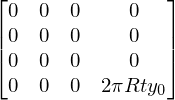

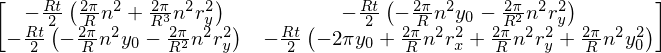

In [8]:
W_rim_0 = zeros(4)

for i in range(4):
    for j in range(4):
        W_rim_0[i, j] = -V_rim.subs(n, 0).diff(d[2*i]).diff(d[2*j])
        
display(W_rim_0)

W_rim_n = zeros(8)

for i, m1 in enumerate(d):
    for j, m2 in enumerate(d):
        W_rim_n[i, j] = -V_rim.subs(n, npos).diff(m1).diff(m2)
        
display(W_rim_n[[0, 6],[0, 6]])

# Spokes stiffness matrix

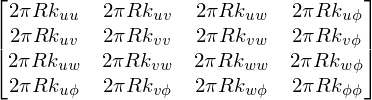

In [9]:
K_spk_0 = zeros(4)

for i in range(4):
    for j in range(4):
        K_spk_0[i, j] = U_spokes.subs(n, 0).diff(d[2*i]).diff(d[2*j])
        
display(K_spk_0)

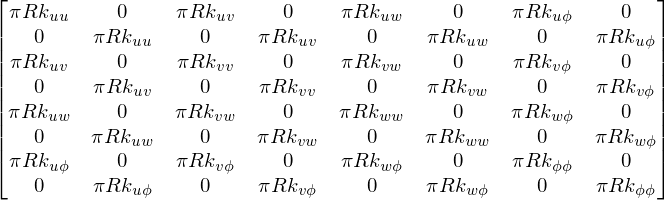

In [10]:
K_spk_n = zeros(8)

for i, m1 in enumerate(d):
    for j, m2 in enumerate(d):
        K_spk_n[i, j] = U_spokes.subs(n, npos).diff(m1).diff(m2)
        
display(K_spk_n)

# Buckling criterion

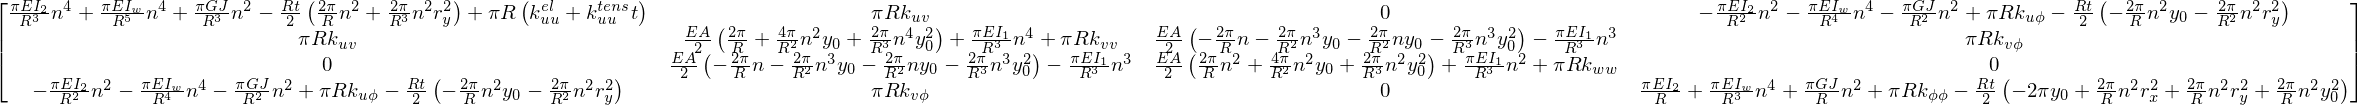

In [12]:
kuu_el, kuu_tens = symbols('k_uu^el k_uu^tens', real=True)

K = (K_spk_n + K_rim_n + W_rim_n).subs(k_uu, kuu_el + t*kuu_tens)

#      u_c, v_c, w_s, phi_c
idx = [0,   2,   5,   6]

K_b = K[idx, idx]
display(K_b)

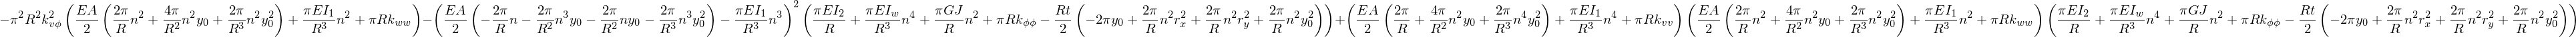

In [13]:
K_b[[1, 2, 3], [1, 2, 3]].det()

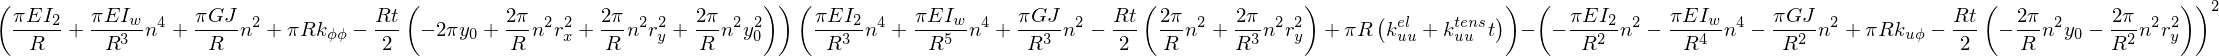

In [14]:
buckling_crit = K[0, 0]*K[6, 6] - K[0, 6]**2

display(buckling_crit)

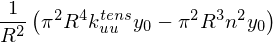

In [18]:
p = Poly(buckling_crit.expand(), t)

display(p.coeffs()[0].subs([(rx**2, 0), (ry**2, 0), (y0**2, 0)]))

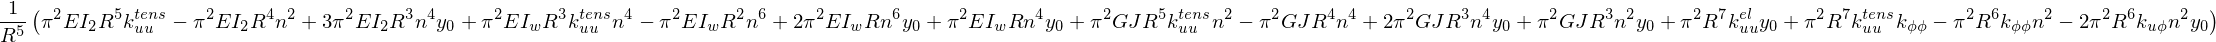

In [16]:
display(p.coeffs()[1].subs([(rx**2, 0), (ry**2, 0), (y0**2, 0)]))

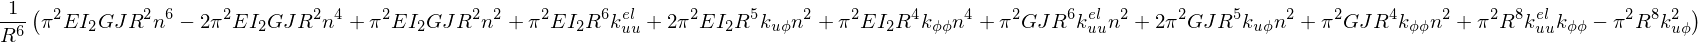

In [17]:
display(p.coeffs()[2].subs([(rx**2, 0), (ry**2, 0), (y0**2, 0), (EIw, 0)]))